In [1]:
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image
import numpy as np
import importlib
import sys
import torch
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from img_resize import bulk_resize
import torch.nn as nn
from trigger import *
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
config = {
    'random_seed':50,
    'path':'/home/user01/repo/experiments/codes/hb/',
    'data_path':'../../../../temp-data',
    'trigger_shape':(4,4,3),
    'return_nodes':{'features.7':'features.7'},
    'feature_layer':'features.7',
    'num_poisons':100,
    'num_triggers':10,
    'pois_learning_rate':1e-2,
    'pois_epochs':100000,
    'pois_lr_decay':0.95,
    'pois_decay_step':2000,
    'pois_min_loss':1.5,
    'pois_epsilon':16/255,
    'pois_source_class':4,
    'pois_target_class':5,
    'pois_image_shape':(32, 32),
    'ft_batch_size':32,
    'ft_learning_rate':0.1,
    'ft_num_epochs':150
}

In [3]:
seed = config['random_seed']
np.random.seed(seed)
torch.random.manual_seed(seed)

In [4]:
def _reload(fn):
  return importlib.reload(fn)

In [5]:
sys.path.append(config['path'])

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading the Dataset

In [7]:
trainset = datasets.CIFAR10(root=config['data_path'], train=True, download=True, transform=None)

Files already downloaded and verified


In [8]:
data_x = trainset.data.copy()
data_x = np.array([cv2.resize(np.uint8(img), config['pois_image_shape']) for img in data_x])
data_y = trainset.targets[:]

In [9]:
del trainset

# Generating some Triggers

In [12]:
gen = TriggerGenerator(config['trigger_shape'])
triggers = gen.generate(config['num_triggers'])
#triggers = [cv2.resize(np.uint8(trigger*255), (10,10)) for trigger in triggers]

# Model

In [13]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='AlexNet_Weights.IMAGENET1K_V1')

Using cache found in /home/user01/.cache/torch/hub/pytorch_vision_v0.10.0


In [14]:
# fixing the weights of the model
for param in model.parameters():
    param.requires_grad = False

In [15]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
get_graph_node_names(model)

(['x',
  'features.0',
  'features.1',
  'features.2',
  'features.3',
  'features.4',
  'features.5',
  'features.6',
  'features.7',
  'features.8',
  'features.9',
  'features.10',
  'features.11',
  'features.12',
  'avgpool',
  'flatten',
  'classifier.0',
  'classifier.1',
  'classifier.2',
  'classifier.3',
  'classifier.4',
  'classifier.5',
  'classifier.6'],
 ['x',
  'features.0',
  'features.1',
  'features.2',
  'features.3',
  'features.4',
  'features.5',
  'features.6',
  'features.7',
  'features.8',
  'features.9',
  'features.10',
  'features.11',
  'features.12',
  'avgpool',
  'flatten',
  'classifier.0',
  'classifier.1',
  'classifier.2',
  'classifier.3',
  'classifier.4',
  'classifier.5',
  'classifier.6'])

In [17]:
feature_ext = create_feature_extractor(model, return_nodes=config['return_nodes'])

In [18]:
def feature_extractor(x: torch.Tensor):
  return feature_ext(torch.Tensor(x.transpose(0,3,1,2)))[config['feature_layer']]

# Launching the Attack

In [19]:
from hiddenbackdoor import *

In [20]:
hb = HiddenBackdoor(data_x/255, data_y, config['pois_source_class'], config['pois_target_class'],
                    triggers[0]/255, feature_ext,
                    config['feature_layer'], config['pois_epsilon'])

In [21]:
poison = hb.run(num_poisons=config['num_poisons'], learning_rate=config['pois_learning_rate'],
                epochs=config['pois_epochs'], lr_decay=config['pois_lr_decay'],
                lr_decay_step=config['pois_decay_step'], min_loss=config['pois_min_loss'])

 epoch 99999 - loss: 1.4795019626617432CPU times: user 35min 33s, sys: 19.9 s, total: 35min 53s
Wall time: 8min 3s


Generated Poison

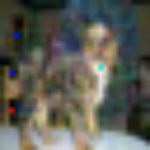

In [22]:
Image.fromarray(cv2.resize(np.uint8(poison[2]*255), (150,150))).show()

The corresponding target

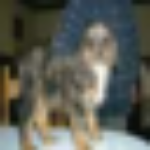

In [23]:
Image.fromarray(cv2.resize(np.uint8(hb.target_images[2]*255), (150,150))).show()

The stamped (triggered) source

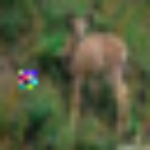

In [24]:
Image.fromarray(cv2.resize(np.uint8(hb.patched_source_images[2]*255), (150,150))).show()

# New Model

In [51]:
class TransferModel(nn.Module):
    def __init__(self, base_model, layer_name: str):
        super().__init__()
        self.layer_name = layer_name
        self.base_model = base_model
        self.classifier = nn.Linear(in_features=384, out_features=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.base_model(x)[self.layer_name].squeeze()
        out = self.classifier(out)
        out = self.sigmoid(out)
        return out

In [52]:
transfer_model = TransferModel(feature_ext, config['feature_layer']).to(device)

In [53]:
transfer_model(torch.Tensor(poison[:5].transpose(0, 3, 1, 2)).to(device)).shape

torch.Size([5, 1])

# Fine-tuning Dataset

In [54]:
finetune_ids = []
for idx, _y in enumerate(data_y):
    if _y in {config['pois_source_class'], config['pois_target_class']}:
        finetune_ids.append(idx)

In [56]:
ft_x = data_x[finetune_ids].transpose(0, 3, 1, 2)
ft_y = np.array(data_y)[finetune_ids]
ft_x = np.concatenate((ft_x, poison.transpose(0, 3, 1, 2)), axis=0)
ft_y = np.concatenate((ft_y,
                       np.array([config['pois_target_class'] for i in range(config['num_poisons'])])), axis=0)

In [58]:
ft_x.shape

(10100, 3, 32, 32)

In [59]:
label_mapping = {
    config['pois_source_class']:0,
    config['pois_target_class']:1
}
ft_y = np.array([label_mapping[label] for label in ft_y])

# Fine-tuning the Model

In [62]:
class MyVectorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = np.array(labels).reshape(-1, 1)
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        return torch.Tensor(self.features[idx]).to(device), torch.Tensor(self.labels[idx]).to(device)

In [63]:
train_dataset = MyVectorDataset(ft_x, ft_y)

In [64]:
train_dataloader = DataLoader(train_dataset, batch_size=config['ft_batch_size'], shuffle=True)

In [65]:
loss_fn = nn.BCELoss()
# optimizer = torch.optim.SGD(transfer_model.parameters(), lr=config['ft_learning_rate'])
optimizer = torch.optim.Adam(transfer_model.parameters(),lr=config['ft_learning_rate'],betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)

In [66]:
def output_to_label(out):
    out = out.squeeze()
    dist_to_0 = abs(out)
    dist_to_1 = abs(out-1)
    if dist_to_0 <= dist_to_1:
        return 0
    else:
        return 1

In [67]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_num):
    num_points = len(dataloader.dataset)
    for batch, (features, labels) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(features)
        loss = loss_fn(pred, labels)

        # Backpropagation
        optimizer.zero_grad() # sets gradients of all model parameters to zero
        loss.backward() # calculate the gradients again
        optimizer.step() # w = w - learning_rate * grad(loss)_with_respect_to_w

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(features)
            print(f"\r Epoch {epoch_num} - loss: {loss:>7f}  [{current:>5d}/{num_points:>5d}]", end=" ")


def test_loop(dataloader, model, loss_fn, epoch_num, name):
    num_points = len(dataloader.dataset)
    sum_test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (features, labels) in enumerate(dataloader):
            pred = model(features)
            sum_test_loss += loss_fn(pred, labels).item() # add the current loss to the sum of the losses
            # convert the outputs of the model on the current batch to a numpy array
            pred_lst = list(pred.cpu().detach().numpy().squeeze())
            pred_lst = [output_to_label(item) for item in pred_lst]
            # convert the original labels corresponding to the current batch to a numpy array
            output_lst = list(labels.cpu().detach().numpy().squeeze())
            # determine the points for which the model is correctly predicting the label (add a 1 for each)
            match_lst = [1 if p==o else 0 for (p, o) in zip(pred_lst, output_lst)]
            # count how many points are labeled correctly in this batch and add the number to the overall count of the correct labeled points
            correct += sum(match_lst)

    sum_test_loss /= num_points
    correct /= num_points
    print(f"\r Epoch {epoch_num} - {name} Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {sum_test_loss:>8f}")

In [68]:
for epoch_num in range(1, config['ft_num_epochs']+1):
    train_loop(train_dataloader, transfer_model, loss_fn, optimizer, epoch_num)

 Epoch 150 - loss: 59.375000  [ 9600/10100] 

In [69]:
model_out = transfer_model(torch.Tensor(ft_x).to(device)).squeeze().cpu().detach().numpy()

In [70]:
model_out.shape

(10100,)

In [77]:
pred_labels = [output_to_label(pred) for pred in model_out]
(pred_labels==ft_y).sum()

5000

In [78]:
np.unique(model_out[:])

array([0.0000000e+00, 3.1779908e-39, 3.3145109e-39, 5.2018217e-39,
       5.9745299e-39, 9.0578139e-39, 9.4652442e-39, 1.7020500e-38,
       1.9414012e-38, 2.1735693e-38, 3.6296167e-38, 6.3298199e-38,
       7.2265102e-38, 2.7843161e-37, 3.3395929e-37, 1.0948767e-36,
       3.2512879e-36, 3.6404089e-36, 8.0348684e-36, 2.6833798e-35],
      dtype=float32)

In [80]:
ft_y.shape

(10100,)